In [18]:
# All Imports
import warnings
warnings.filterwarnings("ignore")

import os
from datetime import datetime

import librosa
from scipy.io import wavfile
import numpy as np
import pandas as pd
import sklearn as sk
import tensorflow as tf
import torch
from torch.utils import data
import keras
from keras import models
from keras import layers
from keras.backend import manual_variable_initialization, tensorflow_backend
from sklearn import model_selection
from sklearn.metrics import confusion_matrix

import IPython.display as ipd
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

In [2]:
#SETUP Environment stuff (GPU, keras saving/loading config)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
      # Memory growth must be set before GPUs have been initialized
      print(e)

print(tensorflow_backend._get_available_gpus())

np.random.seed(42)
tf.random.set_seed(42)
manual_variable_initialization(True)

1 Physical GPUs, 1 Logical GPUs
['/job:localhost/replica:0/task:0/device:GPU:0']


In [3]:
# Configs for Machine Learning


##### Loading Test/Training Data #####
load_urbansound_data = True
# Data Source: https://urbansounddataset.weebly.com/urbansound8k.html
load_birds_data      = False
# Data Source: http://machine-listening.eecs.qmul.ac.uk/bird-audio-detection-challenge/#downloads
load_kaggle_data     = False
# Data Source: https://www.kaggle.com/mmoreaux/environmental-sound-classification-50#esc50.csv


##### Loading/Saving Model #####
# load_model_file = False # False = create new model, String = load pre-trian model from file.
# save_model_file = "urbansound_first_try" # False = do nothing, String = save trained model to file.
load_model_file = "urbansound_first_try"
save_model_file = False


##### Training / Fitting / Optimizing Model #####
test_size = 0.2
epochs    = 100
optimizer = keras.optimizers.Adam(learning_rate=1e-5, beta_1=0.9, beta_2=0.999, amsgrad=False)

In [4]:
##### HELPER FUNCTIONS #####
# extract_features
# load_all_wav_files
# save_model
# load_model
# plot_history (loss & accuracy v epochs)
# plot_confusion_matrix

In [5]:
def extract_features(file_name):
    """
    Extracts 193 chromatographic features from sound file. 
    including: MFCC's, Chroma_StFt, Melspectrogram, Spectral Contrast, and Tonnetz
    NOTE: this extraction technique changes the time series nature of the data
    """
    audio_data, sample_rate = librosa.load(file_name)
    stft = np.abs(librosa.stft(audio_data))
    mfcc = np.mean(librosa.feature.mfcc(y=audio_data, sr=sample_rate, n_mfcc=40).T,axis=0)
    chroma = np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T,axis=0)
    mel = np.mean(librosa.feature.melspectrogram(audio_data, sr=sample_rate).T,axis=0)
    contrast = np.mean(librosa.feature.spectral_contrast(S=stft, sr=sample_rate).T,axis=0)
    # More possible features to add
#     tonnetz = np.mean(librosa.feature.tonnetz(y=librosa.effects.harmonic(X, ), sr=sample_rate).T,axis=0)
#     spec_cent = np.mean(librosa.feature.spectral_centroid(y=audio_data, sr=sample_rate).T, axis=0)
#     spec_bw = np.mean(librosa.feature.spectral_bandwidth(y=audio_data, sr=sample_rate).T, axis=0)
#     rolloff = np.mean(librosa.feature.spectral_rolloff(y=audio_data, sr=sample_rate).T, axis=0)
#     zcr = np.mean(librosa.feature.zero_crossing_rate(audio_data).T, axis=0)

    features = []
    features.extend(mfcc) # 40 = 40
    features.extend(chroma) # 12 = 52
    features.extend(mel) # 128 = 180
    features.extend(contrast) # 7 = 187
    
    
#     features.extend(tonnetz) # 6 = 193
#     features.extend(spec_cent)
#     features.extend(spec_bw)
#     features.extend(rolloff)
#     features.extend(zcr)

    return np.array(features)

In [6]:
def load_all_wav_files(load_urbansound=False,
                       load_birds=False,
                       load_kaggle=False):
    #THIS WILL TAKE A WHILE!!!!!
    all_data = []
    all_labels = []

    #UltraSound8K
    if load_urbansound:
        print("loading Ultrasound8k")
        # Data Source: https://urbansounddataset.weebly.com/urbansound8k.html
        metadata = pd.read_csv("./data/UrbanSound8K/metadata/UrbanSound8K.csv")
        for root, dirs, files in os.walk("./data/UrbanSound8K"):
            print(root, str(len(dirs)), str(len(files)), len(all_data))
    #       # This is in here for quick tests - only loads first Ultrasound8k folder (instead of all of them)
            if len(all_data) > 0: 
                break
            for idx, file in enumerate(files):
                if file.endswith('.wav'):
                    if(len(all_data) % 100 == 0):
                        print(str(len(all_data)))
                    fname = os.path.join(root, file)
                    features = extract_features(fname)
                    label = metadata[metadata.slice_file_name == file]["class"].tolist()[0]
                    all_data.append(features)
                    all_labels.append(label)


    if load_birds:
        print("Loading birds")
        # Data Source: http://dcase.community/challenge2018/task-bird-audio-detection
        # Data Source: http://machine-listening.eecs.qmul.ac.uk/bird-audio-detection-challenge/#downloads
        for root, dirs, files in os.walk("./data/warblrb10k_public_wav/train/hasbird"):
            print(root, str(len(dirs)), str(len(files)), len(all_data))
            for file in files:
                if file.endswith('.wav'):
                    if(len(all_data) % 100 == 0):
                        print(str(len(all_data)))
                    fname = os.path.join(root, file)
                    features = extract_features(fname)
                    all_data.append(features)
                    all_labels.append("bird")
    
    if load_kaggle:
        print("Loading Kaggle")
        # Data Source: https://www.kaggle.com/mmoreaux/environmental-sound-classification-50#esc50.csv
        metadata = pd.read_csv("./data/environmental-sound-classification-50/esc50.csv")
        #for root, dirs, files in os.walk("./data/environmental-sound-classification-50/"):
        for file in os.listdir("./data/environmental-sound-classification-50/audio"):
            fname = "./data/environmental-sound-classification-50/audio/"+file
#            for file in files:
#                 print(file)
#                 print(metadata[metadata.filename == file])
            if file.endswith('.wav'):
                label = metadata[metadata.filename == file]["category"].tolist()[0]
                animals=["cat", "chirping_birds","cow","crickets","crow","dog","frog","hen","insects","pig","rooster","sheep"]
                if label in animals:
                    #label_idx = animals.index(label)
                    if(len(all_data) % 100 == 0):
                        print(str(len(all_data)))
    #                         fname = os.path.join(root, file)
    #                         features = extract_feature(fname)
                    features = extract_features(fname)
                    all_data.append(features)
                    all_labels.append(label)

    return np.array(all_data), np.array(all_labels)

In [7]:
def save_model(model, fname="model"):
    # Saves keras model in two files:
    #   .json = model architecture
    #   .h5 = model HDF5 weights
    model_json = model.to_json()
    fpath = os.path.join("model", fname)
    with open(fpath + ".json", "w") as json_file:
        json_file.write(model_json)
    model.save_weights(fpath + ".h5")
    print("Saved model and weights to " + fpath)

In [8]:
def load_model(fname="model"):
    # load json and create (keras) model
    loaded_model_json = None
    fpath = os.path.join("model", fname)
    with open(fpath + ".json", 'r') as json_file:
        loaded_model_json = json_file.read()
    loaded_model = models.model_from_json(loaded_model_json)
    # load weights into new model
    loaded_model.load_weights(fpath + ".h5")
    print("Loaded model and weights from " + fpath)
    return loaded_model

In [9]:
def analyze_features(all_data, all_labels):
    #seeking only the numeric features from the data
    numeric_features = all_data.select_dtypes(include = [np.number])
    print(numeric_features.dtypes)
    corr = numeric_features.corr()
    print(corr)
#     print(corr['SalePrice'].sort_values(ascending = False)[:5], '\n')
#     print(corr['SalePrice'].sort_values(ascending = False)[-5:])

In [10]:
def plot_history(history = None):
    if not history:
        print("No history to plot")
        return
    fig = plt.figure(figsize=(10,8))
    plt.plot(history.history['loss'], label="Loss")
    plt.plot(history.history['accuracy'], label="Accuracy")
    plt.axis([0,90,0,np.max(history.history['accuracy'])])
    plt.title("Accuracy and Loss vs Epoch")
    plt.xlabel("Epoch")
    plt.ylabel("Percentage")
    plt.legend()
    plt.show()

In [11]:
def plot_confusion_matrix(cm):
    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes,
           yticklabels=classes,
           title="Confusion Matrix",
           ylabel='True label',
           xlabel='Predicted label')
    ax.set_ylim(len(classes)-0.5, -0.5)
    ax.set_aspect('auto')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], 'd'),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")

    plt.grid(None)
    plt.show()

In [12]:
all_data, all_labels = load_all_wav_files(load_urbansound_data,
                                          load_birds_data,
                                          load_kaggle_data)
# np.savetxt("data/temp_all_data.txt", all_data)
# np.savetxt("data/temp_all_labels.txt", all_labels)

loading Ultrasound8k
./data/UrbanSound8K 2 3 0
./data/UrbanSound8K\audio 10 1 0
./data/UrbanSound8K\audio\fold1 0 874 0
0
100
200
300
400
500
600
700
800
./data/UrbanSound8K\audio\fold10 0 838 873


In [20]:
# analyze_features(all_data, all_labels)
# all_data = np.loadtxt("data/temp_all_data.txt")
# all_labels = np.loadtxt("data/temp_all_labels.txt")

In [14]:
print(all_data.shape)
classes = list(set(all_labels)) # classes = unique list of labels
n_classes = len(classes)
numeric_labels = np.array([classes.index(label) for label in all_labels]) # labels by index
print(classes)

(873, 187)
['siren', 'jackhammer', 'dog_bark', 'drilling', 'car_horn', 'street_music', 'air_conditioner', 'children_playing', 'engine_idling', 'gun_shot']


In [15]:
x_train, x_test, y_train, y_test = sk.model_selection.train_test_split(all_data, numeric_labels, test_size=test_size, shuffle=True)

In [16]:
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(698, 187)
(698,)
(175, 187)
(175,)


In [23]:
x_train_torch = torch.from_numpy(x_train).to(device)
y_train_torch = torch.from_numpy(y_train).to(device)

train_dataset = torch.utils.data.TensorDataset(x_train_torch, y_train_torch)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=10)

In [25]:
# model = models.Sequential()
# model.add(layers.Dense(256, activation='relu', input_shape=(x_train.shape[1],)))
# model.add(layers.Dense(128, activation='relu'))
# model.add(layers.Dense(64, activation='relu'))
# model.add(layers.Dense(n_classes, activation='softmax'))
model = torch.nn.Sequential(
          torch.nn.Conv2d(x_train.shape[1], 256, 5),
          torch.nn.ReLU(),
          torch.nn.Conv2d(256, 128, 5),
          torch.nn.ReLU(),
          torch.nn.Conv2d(128, 64, 5),
          torch.nn.ReLU(),
          torch.nn.Conv2d(64, n_classes, 5)
        ).to(device)

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

In [28]:
for epoch in range(epochs):  # loop over the dataset multiple times
    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        # get the inputs
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

RuntimeError: Expected 4-dimensional input for 4-dimensional weight [256, 187, 5, 5], but got 2-dimensional input of size [1, 187] instead

In [ ]:
# class Net(torch.nn.Module):
#     def __init__(self):
#         super(Net, self).__init__()
#         self.conv1 = torch.nn.Conv2d(3, 6, 5) # 6x28x28
#         self.pool = torch.nn.MaxPool2d(2, 2) # 6x14x14 1st time, 16x5x5 2nd time
#         self.conv2 = torch.nn.Conv2d(6, 16, 5) # 16x10x10
#         self.fc1 = torch.nn.Linear(16 * 5 * 5, 120)
#         self.fc2 = torch.nn.Linear(120, 84)
#         self.fc3 = torch.nn.Linear(84, 10)

#     def forward(self, x):
#         x = self.pool(torch_func.relu(self.conv1(x))) # 1st Conv. Layer + kernel
#         x = self.pool(torch_func.relu(self.conv2(x))) # 2nd Conv. Layer + kernel
#         x = x.view(-1, 16 * 5 * 5) 
#         x = torch_func.relu(self.fc1(x))
#         x = torch_func.relu(self.fc2(x))
#         x = self.fc3(x)
#         return x
    
# net = Net()
# if torch.cuda.is_available():
#     net.to(device)

In [16]:
# model = None
# if load_model_file:
# #     loaded_model_json = None
# #     fpath = os.path.join("model", load_model_file)
# #     with open(fpath + ".json", 'r') as json_file:
# #         loaded_model_json = json_file.read()
# #     model = models.model_from_json(loaded_model_json)
# #     # load weights into new model
# #     model.load_weights(fpath + ".h5")
#     model = load_model(load_model_file)
# else:
#     model = models.Sequential()
#     model.add(layers.Dense(256, activation='relu', input_shape=(x_train.shape[1],)))
#     model.add(layers.Dense(128, activation='relu'))
#     model.add(layers.Dense(64, activation='relu'))
#     model.add(layers.Dense(n_classes, activation='softmax'))

model = models.Sequential()
model.add(layers.Dense(256, activation='relu', input_shape=(x_train.shape[1],)))
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(n_classes, activation='softmax'))

if load_model_file:
    fpath = os.path.join("model", load_model_file)
    model.load_weights(fpath + ".h5")
    
model.compile(optimizer=optimizer,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [17]:
history = None
if not load_model_file:
    history = model.fit(x_train, y_train, epochs=epochs, batch_size=10)

In [18]:
test_loss, test_acc = model.evaluate(x_test, y_test)
print('test_acc: ',test_acc)

175/175 [==============================] - 0s 1ms/step
test_acc:  0.0


In [19]:
if not load_model_file and save_model_file:
    save_model(model, save_model_file)

In [20]:
y_pred_percentages = model.predict(x_test) # predicted percentages

y_pred = np.argmax(y_pred_percentages, axis=1) # Most prevalent prediction

cm = confusion_matrix(y_test, y_pred)

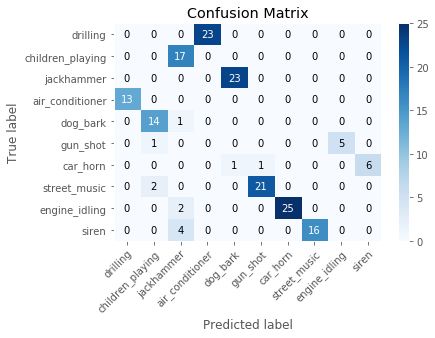

In [21]:
plot_confusion_matrix(cm)

In [22]:
plot_history(history)

No history to plot
